In [1]:
import torch
from torchvision import datasets,transforms
import matplotlib.pyplot as plt

In [2]:
# device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
target_size = (512,512)
batch_size = 12
total_epoch = 40
learning_rate = 1e-4

In [3]:
import random
import numpy as np

def set_seed(seed=2025):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)     
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)

set_seed()

In [4]:
import os 
from torch.utils.data import Dataset
from torchvision.io import decode_image
import pandas as pd 
from PIL import Image

class PetFinderDataset(Dataset):
    def __init__(self,csv_path,transform=None):
        self.root =os.path.dirname(csv_path)
        self.root = os.path.join(self.root,"train")
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, f"{self.df.iloc[idx, 0]}.jpg")
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [5]:
class CustomResizeCrop:
    def __init__(self, target_size=(1024, 1024)):
        self.target_size = target_size

    def __call__(self, img):
        original_width, original_height = img.size
        scale_ratio = max(self.target_size[0] / original_width, self.target_size[1] / original_height)
        
        if scale_ratio > 1:  
            new_size = (int(original_height * scale_ratio), int(original_width * scale_ratio))
            transform = transforms.Compose([
                transforms.Resize(new_size,),
                transforms.CenterCrop(self.target_size)
            ])
        else:  
            transform = transforms.Compose([
                transforms.Resize(self.target_size,),
                transforms.CenterCrop(self.target_size)
            ])
            
        return transform(img)


In [6]:
# only run once

def split_train_val(data_set_dir = "data/petfinder-pawpularity-score"):
    df = pd.read_csv(os.path.join(data_set_dir,"train.csv"))
    train_ratio = 0.9
    train_size = int(len(df) * train_ratio)
    train_df = df.sample(n=train_size, random_state=42).reset_index(drop=True)
    val_df = df.drop(train_df.index).reset_index(drop=True)
    train_df.to_csv(os.path.join(data_set_dir,'diffusion_train.csv'), index=False)
    val_df.to_csv(os.path.join(data_set_dir,'diffusion_val.csv'), index=False)

split_train_val()

In [7]:

transform = transforms.Compose([
    CustomResizeCrop(target_size),
    transforms.ToTensor(),
])


train_data = PetFinderDataset("data/petfinder-pawpularity-score/diffusion_train.csv",transform)
test_data = PetFinderDataset("data/petfinder-pawpularity-score/diffusion_val.csv",transform)


In [8]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True,)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True,)

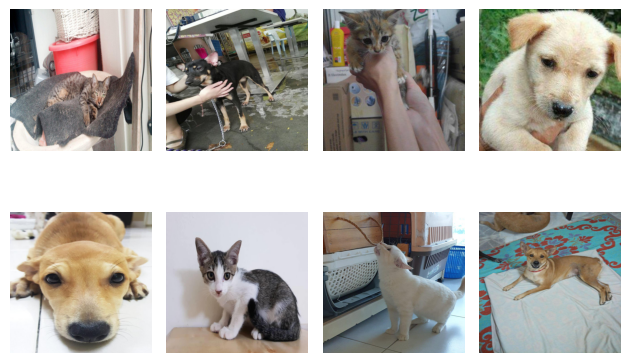

In [9]:
def display_dataset(dataloader):
    show_img_num = min(batch_size,8)
    display_imgs = next(iter(dataloader))
    fig, axes = plt.subplots(2, show_img_num//2)  
    axes = axes.flatten()
    for i in range(show_img_num):
        img = display_imgs[i].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis('off') 
    plt.tight_layout()
    plt.show()
    
display_dataset(test_dataloader)

In [10]:
import torch.nn as nn
class ToyModel(nn.Module):
    """
        一个简单的UNet网络
    """
    def __init__(self,time_emb_dim = 32):
        super().__init__()
        
        # 对正余弦的编码结果，再使用mlp进行一次编码，让编码过程是可学习的
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 2),
            nn.ReLU(),
            nn.Linear(time_emb_dim * 2, time_emb_dim * 2)
        )
        # 时间编码的结果向高维映射，方便和卷积层拼接
        self.time_emb_proj = nn.Linear(time_emb_dim * 2, 256)   
        
        # 三个用于编码的卷积层
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        
        self.bottleneck = self.conv_block(256, 512)

        # 三个用于解码的卷积层  
        self.dec3 = self.conv_block(512 + 256, 256) 
        self.dec2 = self.conv_block(256 + 128, 128)
        self.dec1 = self.conv_block(128 + 64, 64)
        
        # 池化用于下采样
        self.pool = nn.MaxPool2d(2)
        # bilinear的方式上采样
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        # 最终输出的卷积层
        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)
     
    def conv_block(self, in_channels, out_channels):
        """
            一个简单的卷积Block,不改变图片的长宽, 只改变图片的通道数
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def get_time_embedding(self, timestep, dim=32, max_period=10000):
        """
            正余弦时间编码, 这里参考Transformer的 正余弦位置编码, 道理都是一样的
        """
        half = dim // 2
        freqs = torch.exp(-torch.arange(half, dtype=torch.float32) * torch.log(torch.tensor(max_period)) / half).to(timestep.device)
        args = timestep.unsqueeze(-1).float() * freqs.unsqueeze(0)  # (B, half)
        embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)  # (B, dim)
        return embedding
    
    def forward(self, x,t):
        batch_size = x.shape[0]
        # 先进行时间映射
        t_emb = self.get_time_embedding(t).to(x.device)  # (batch_size, time_emb_dim)
        t_emb = self.time_mlp(t_emb)  # (batch_size, time_emb_dim*2)
        time_emb = self.time_emb_proj(t_emb)  # (B, 256)
        time_emb = time_emb.view(batch_size, -1, 1, 1)  # (B, 256, 1, 1)  变换成和中间层的卷积同样的维度，这样通过广播加法可以很容易的apply到卷积层里
        # 编码过程 (编码 -> 下采样) -> (编码 -> 下采样) -> (编码 -> 下采样)
        e1 = self.enc1(x)         # (B, 64, 32, 32)
        e2 = self.enc2(self.pool(e1))  # (B, 128, 16, 16)
        e3 = self.enc3(self.pool(e2))  # (B, 256, 8, 8)
        
        # 在bottleneck之前，apply时间编码
        e3 = e3 + time_emb  # 广播加法
        b = self.bottleneck(self.pool(e3))  # (B, 512, 4, 4)

        # 解码过程 (上采样 -> 拼接 -> 解码) -> (上采样 -> 拼接 -> 解码) -> (上采样 -> 拼接 -> 解码)
        d3 = self.upsample(b)  # (B, 512, 8, 8)
        d3 = torch.cat([d3, e3], dim=1)  # (B, 512+256, 8, 8)
        d3 = self.dec3(d3)     # (B, 256, 8, 8)
        d2 = self.upsample(d3) # (B, 256, 16, 16)
        d2 = torch.cat([d2, e2], dim=1)  # (B, 256+128, 16, 16)
        d2 = self.dec2(d2)     # (B, 128, 16, 16)
        d1 = self.upsample(d2) # (B, 128, 32, 32)
        d1 = torch.cat([d1, e1], dim=1)  # (B, 128+64, 32, 32)
        d1 = self.dec1(d1)     # (B, 64, 32, 32)

        # 最终输出
        out = self.final_conv(d1)  # (B, 3, 32, 32)
        return out


In [11]:
import numpy as np
class Diffusion:
    def __init__(self,beta_start = 0.0001, beta_end = 0.02 , num_diffusion_timesteps = 1000):
        self.betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = np.cumprod(self.alphas, axis=0)
        self.sqrt_alphas_cumprod = np.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - self.alphas_cumprod)
        self.num_timesteps = int(self.betas.shape[0])

    def add_noise(self,x,t):
        noise = torch.randn_like(x)
        sqrt_alphas_cumprod = torch.from_numpy(self.sqrt_alphas_cumprod[t])
        sqrt_one_minus_alphas_cumprod = torch.from_numpy(self.sqrt_one_minus_alphas_cumprod[t])
        noise_image = sqrt_alphas_cumprod.view(-1, 1, 1, 1) * x + sqrt_one_minus_alphas_cumprod.view(-1, 1, 1, 1) * noise
        return noise_image, noise

    def denoise(self,model,x,t):
        alpha= self.alphas[t]
        sqrt_alpha = np.sqrt(alpha)
        sqrt_one_minus_alpha_cumprod = self.sqrt_one_minus_alphas_cumprod[t]
        beta = self.betas[t]
        x = x.to(device)
        inpu_t = torch.full((x.shape[0],),t).to(device)
        pred_noise = model(x,inpu_t)
        x = (x-(1 -alpha)/sqrt_one_minus_alpha_cumprod*pred_noise)/sqrt_alpha
        if t > 0 :
            x = x + np.sqrt(beta)*torch.randn_like(x).to(device)
        return x

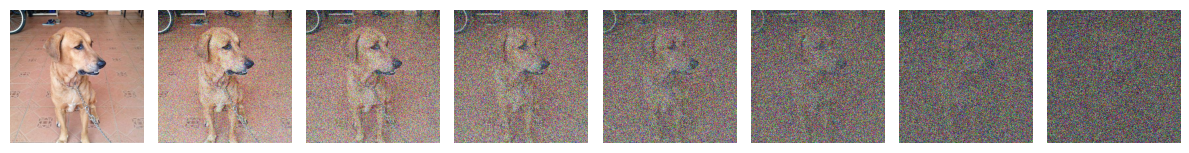

In [12]:
# 展示加噪过程, 这里使用8步展示加噪过程，并且提高了beta_end的数值，这是为了更突出展示的效果
def show_add_noise(dataloader,num_diffusion_timesteps = 8):
    diffusion = Diffusion(beta_start=0,beta_end=0.5,num_diffusion_timesteps =num_diffusion_timesteps)
    fig, axes = plt.subplots(nrows=1, ncols=num_diffusion_timesteps, figsize=(12, 3))
    axes = axes.flatten()
    to_add_noise_img = next(iter(dataloader))
    to_add_noise_img = to_add_noise_img[:1] # for keep batch dim
    for i in range(num_diffusion_timesteps):
        noise_img,_ = diffusion.add_noise(to_add_noise_img, [i])
        img = noise_img[0].permute(1, 2, 0).numpy().clip(0.0,1.0)
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()   

show_add_noise(test_dataloader)

In [13]:
import os
import torch.nn.functional as F
from IPython.display import clear_output
from tqdm import tqdm

def train(model, diffusion, total_epoch, lr=1e-4, model_path=None,):
    model = model.to(device)
    # resume train
    if model_path is not None and os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, weights_only=True))
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0)
    train_losses = []
    val_losses = []
    val_loss_at_step = []

    for epoch in range(total_epoch):
        # 训练
        model.train()
        for imgs in tqdm(train_dataloader):
            t = torch.randint(0, diffusion.num_timesteps, (imgs.shape[0],))
            imgs, noise = diffusion.add_noise(imgs, t)
            imgs = imgs.to(torch.float32).to(device)
            noise = noise.to(device)
            output = model(imgs, t)
            loss = F.mse_loss(output, noise)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_losses.append(loss.item())
            
            if len(train_losses)%20 == 1:
                clear_output(wait=True)
                plt.close()
                plt.figure(figsize=(6, 4))
                plt.plot(train_losses, label="Loss")
                plt.title(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}")
                plt.xlabel("Step")
                plt.ylabel("Loss")
                plt.legend()
                plt.show()
        # 评估
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for imgs in test_dataloader:
                t = torch.randint(0, diffusion.num_timesteps, (imgs.shape[0],))
                imgs, noise = diffusion.add_noise(imgs, t)
                imgs = imgs.to(torch.float32).to(device)
                noise = noise.to(device)
                output = model(imgs, t)
                loss = F.mse_loss(output, noise)
                eval_loss.append(loss.item())
        val_losses.append(sum(eval_loss) / len(eval_loss))
        val_loss_at_step.append(len(train_losses) - 1)

        # 使用matplotlib输出这个epoch的loss曲线
        clear_output(wait=True)
        plt.close()
        plt.figure(figsize=(6, 4))
        plt.plot(train_losses, label="Loss")
        plt.plot(val_loss_at_step, val_losses, label="val_loss")
        plt.title(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f} Val Loss: {val_losses[-1]:.4f}")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()


In [14]:
model = ToyModel()
diffusion = Diffusion()

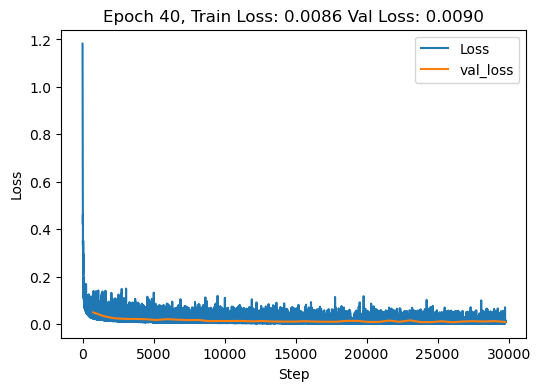

In [15]:
train(model,diffusion,total_epoch,learning_rate,model_path = 'SDE_diffusion_toy_model_weights.pth')
torch.save(model.state_dict(), 'SDE_diffusion_toy_model_weights.pth')

100%|██████████| 1000/1000 [02:23<00:00,  6.98it/s]


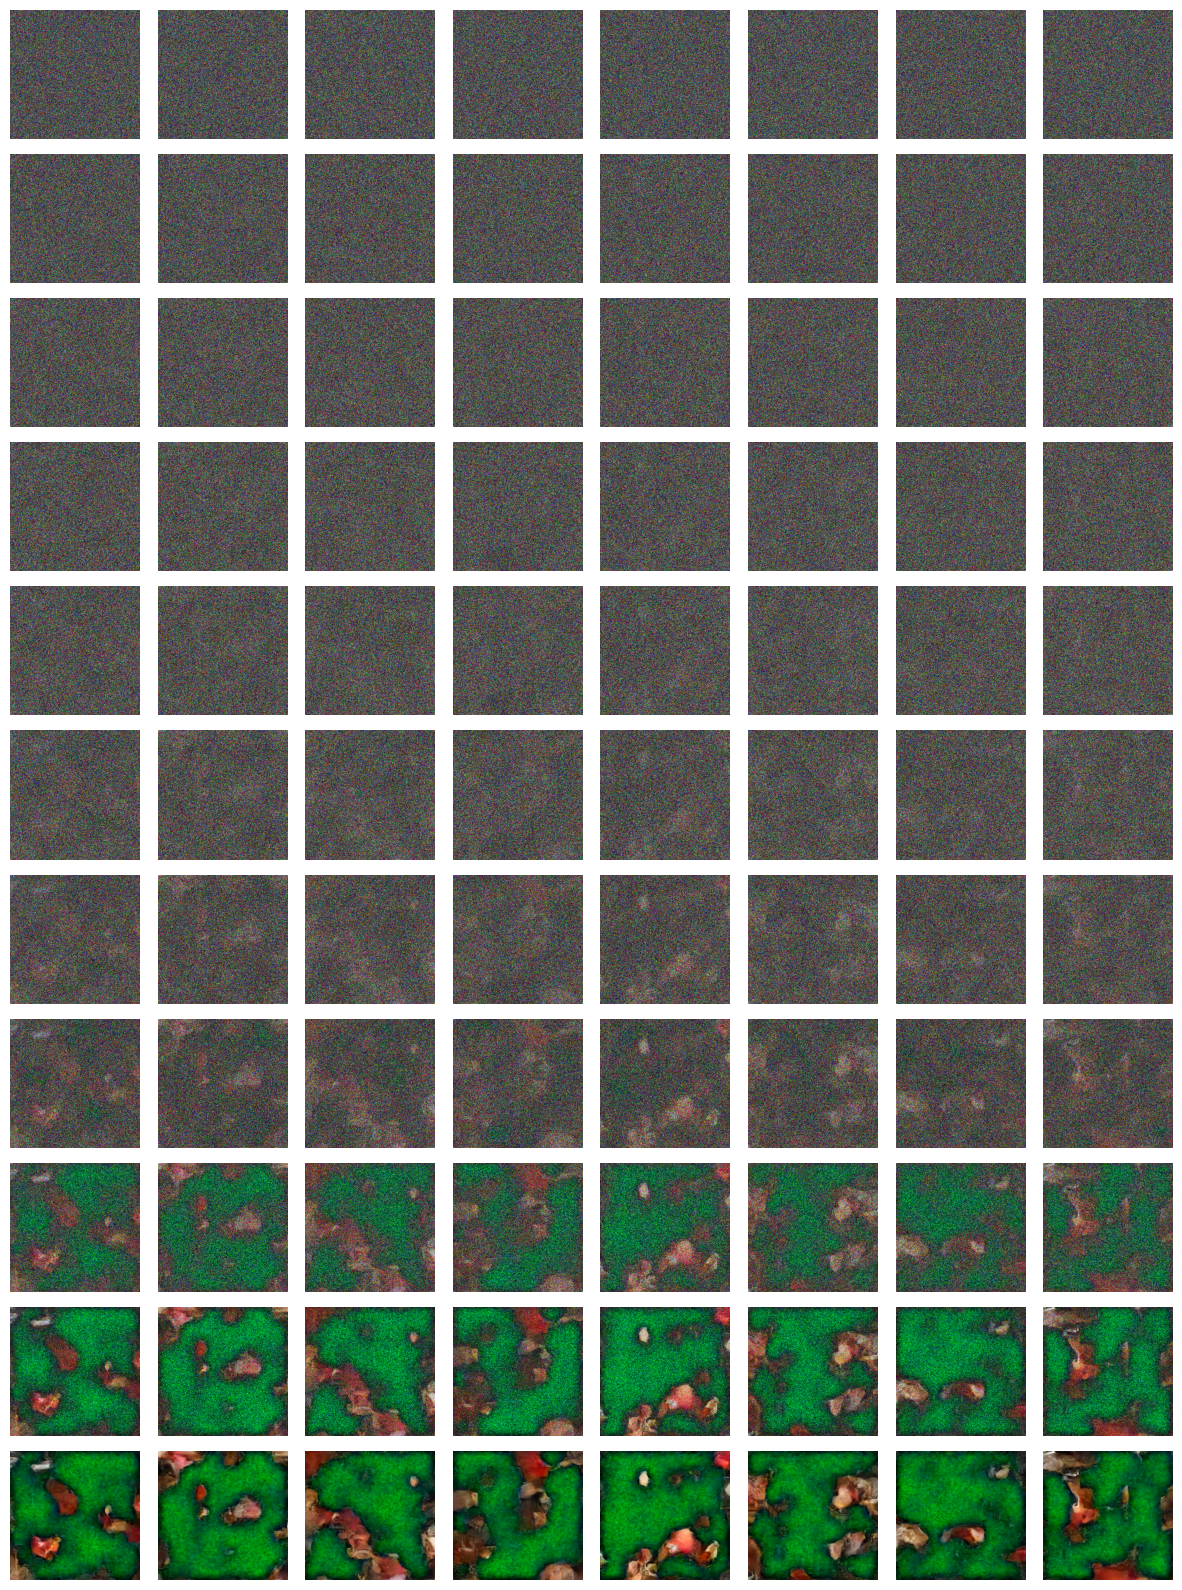

In [18]:
indices = list(range(1000))[::-1]
noise_img = torch.randn(8,3,target_size[0],target_size[1])
show_imgs = [noise_img]
with torch.no_grad():
    model.eval()
    for t in tqdm(indices):
        noise_img = diffusion.denoise(model,noise_img,t)
        if t%100 == 0:
            show_imgs.append(noise_img.cpu())
fig, axes = plt.subplots(len(show_imgs), 8, figsize=(12, 16))  # 可根据需要调整 figsize
axes = axes.flatten()
for step,step_imgs in enumerate(show_imgs):
    for i in range(8):
        axes[step*8+i].imshow(step_imgs[i].permute(1, 2, 0).numpy().clip(0.0,1.0))
        axes[step*8+i].axis('off')  
plt.tight_layout()
plt.show()